In [6]:
from bs4 import BeautifulSoup

# Read the HTML file
with open('recommended_topics.html', 'r', encoding='utf-8') as file:
    html_content = file.read()

# Initialize BeautifulSoup object
soup = BeautifulSoup(html_content, 'html.parser')

# Find all the div tags with the class '_a6_q'
topic_names = []

for div in soup.find_all('td', class_='_2pin _a6_q'):
    # Extract the topic from the nested div inside it
    topic_div = div.find('div')
    if topic_div:
        topic_name = topic_div.get_text(strip=True)
        if topic_name:
            topic_names.append(topic_name)

# Output the list of recommended topics
print("Extracted topics:")
for topic in topic_names:
    print(topic)


Extracted topics:
Crafts
Cars & Trucks by Make & Model
Travel Gear & Accessories
Face Makeup
Foods
TV & Movies Celebrities
Meat & Seafood
Fashion Products
Lip Makeup
Hairstyles
East Asian Food
Dresses
Holiday Decor & Entertaining
Aviation
Ground Transportation
Nail Polish & Art
Nail Care Product Types
Gym Workouts
German Cars & Trucks
Home Entertaining
Fashion
Hair Care Products
European Cars & Trucks
Hair Care & Styling
Regional Cuisines
Drinks
Eye Makeup
Footwear
Personal Celebrations
Fashion Styles & Trends
Music by Genre
Beauty
Skin & Body Care
Dresses & Skirts
Visual Arts
Makeup
Animation TV & Movies
Beauty Product Types
Friendships
Dog Breeds
Nail Care
Huskies
Types of Sports
Baggage
Household Management
Pop Music
Makeup & Cosmetic Product Types
Travel Destinations
Beauty Products
Textile Arts
Europe Travel
Travel
Travel by Region
TV & Movies by Genre
Mammals
Birthdays
Mercedes-Benz Vehicles
Clothing & Accessory Product Types
Dogs
Jewelry
Nails & Nail Care
Cars & Trucks
Asian Foo

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
import numpy as np
from scipy.spatial.distance import cdist

# List of extracted topics
topics = topic_names.copy()

# Step 1: Load the pre-trained Sentence-BERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Step 2: Encode the topics into semantic embeddings (dense vectors)
embeddings = model.encode(topics, show_progress_bar=True)

# Step 3: Apply K-Means Clustering
num_clusters = 7  # You can adjust the number of clusters based on your preference
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(embeddings)

# Step 4: Prepare data for visualization
df = pd.DataFrame({"Topic": topics, "Cluster": kmeans.labels_})

# Step 5: Reduce dimensionality using t-SNE for visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(embeddings)

# Add t-SNE results to the dataframe
df['TSNE-1'] = tsne_results[:, 0]
df['TSNE-2'] = tsne_results[:, 1]


Batches: 100%|██████████| 3/3 [00:00<00:00, 93.66it/s]


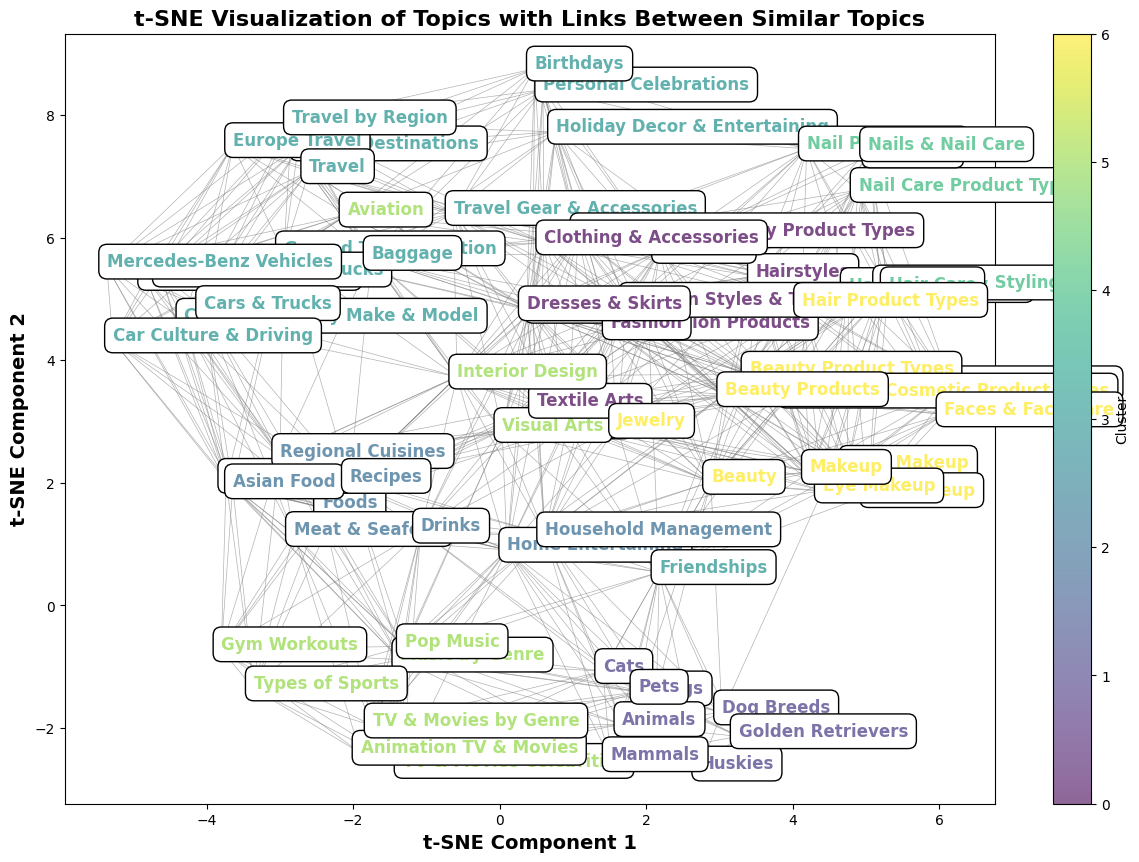

In [22]:
# Step 6: Visualize the clusters in a scatter plot
plt.figure(figsize=(15, 10))
scatter = plt.scatter(df['TSNE-1'], df['TSNE-2'], c=df['Cluster'], cmap='viridis', s=100, alpha=0.6)

# Annotate the points with topic names and add an offset to the labels
offset_x = 0.15  # Adjust horizontal offset to move to the right
offset_y = 0.1  # Adjust vertical offset
for i in range(df.shape[0]):
    cluster = df['Cluster'][i]  # Get the cluster of the current topic
    # Get the color corresponding to the cluster
    cluster_color = scatter.cmap(scatter.norm(cluster))
    
    # Annotate with the background color corresponding to the cluster
    plt.annotate(df['Topic'][i], 
                 (df['TSNE-1'][i], df['TSNE-2'][i]), 
                 fontsize=12,    # Increase font size
                 fontweight='bold',  # Make text bold
                 alpha=0.7,
                    color=cluster_color,  # Set text color to match cluster color
                 xytext=(offset_x, offset_y),  # Offset label position
                 textcoords='offset points',
                 bbox=dict(facecolor='white', boxstyle='round,pad=0.5'))  # Add background color

# Step 7: Add links between similar topics (based on proximity in 2D space)
# Calculate pairwise distances
distances = cdist(df[['TSNE-1', 'TSNE-2']], df[['TSNE-1', 'TSNE-2']], metric='euclidean')

# Set a threshold for adding links (e.g., distance < 4 units)
threshold = 4.0
for i in range(len(df)):
    for j in range(i + 1, len(df)):  # Only check one direction to avoid duplicate lines
        if distances[i, j] < threshold:
            plt.plot([df['TSNE-1'][i], df['TSNE-1'][j]], 
                     [df['TSNE-2'][i], df['TSNE-2'][j]], 
                     color='gray', lw=0.5, alpha=0.6)  # Draw a line between topics

# Add title and labels with larger and bolder font
plt.title("t-SNE Visualization of Topics with Links Between Similar Topics", fontsize=16, fontweight='bold')
plt.xlabel("t-SNE Component 1", fontsize=14, fontweight='bold')
plt.ylabel("t-SNE Component 2", fontsize=14, fontweight='bold')

# Show the plot
plt.colorbar(label="Cluster")
plt.show()
